In [ ]:
!pip install -U tensorflow_text==2.15.*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 46.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
import string
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.keras import layers
from tensorflow.keras import losses

In [ ]:
path = 'drive/MyDrive/dataset/multilabel_comment_dataset.csv'

dataset = pd.read_csv(path, encoding = 'utf8')

dataset.head()

,comment_text,harmful,severe,obscene,threat,insult,discriminate,normal
0,bangladeshi cyclists i notice you did a name c...,0,0,0,0,0,0,1
1,in the ass bitch fucking cock sucker,1,1,1,0,1,1,0
2,ur so immature frnziim and ur not evn debating...,1,0,1,0,1,1,0
3,hi goodday i have noted that qwyrxian has weig...,0,0,0,0,0,0,1
4,for fucks sake just fucking stop you spastic a...,1,1,1,0,1,0,0


In [ ]:
dataset = dataset[:50000]

In [ ]:
# dataset['comment_text'] = dataset['comment_text'].apply(lambda x: x[:300] if len(x) > 300 else x)
# dataset.head()

In [ ]:
raw_train, raw_validation, raw_test = np.split(dataset.sample(frac=1), [int(0.7*len(dataset)), int(0.9*len(dataset))])

print(len(raw_train), 'training examples')
print(len(raw_validation), 'validation examples')
print(len(raw_test), 'test examples')

def df_to_dataset(dataframe, shuffle=True, batch_size=2048):
  df = dataframe.copy()
  labels = df[['harmful', 'severe', 'obscene', 'threat', 'insult', 'discriminate', 'normal']].values
  # labels = df['normal'].values
  df = df['comment_text'].values
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

raw_train_ds = df_to_dataset(raw_train)
raw_val_ds = df_to_dataset(raw_validation)
raw_test_ds = df_to_dataset(raw_test)

35000 training examples
10000 validation examples
5000 test examples


In [ ]:
# max_features = 180000
# sequence_length = 300

# vectorize_layer = tf.keras.layers.TextVectorization(
#     standardize="lower_and_strip_punctuation",
#     max_tokens=max_features,
#     output_sequence_length=sequence_length,
#     output_mode='int'
# )

# train_text = raw_train_ds.map(lambda text, labels: text)
# vectorize_layer.adapt(train_text)

# def vectorize_text(text, label):
#   text = tf.expand_dims(text, -1)
#   return vectorize_layer(text), label

# train_ds = raw_train_ds.map(vectorize_text)
# val_ds = raw_val_ds.map(vectorize_text)
# test_ds = raw_test_ds.map(vectorize_text)

train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
def build_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    # net = outputs['pooled_output'] # [batch_size, 768].
    net = sequence_output = outputs["sequence_output"] # [batch_size, seq_length, 768]


    # net = tf.keras.layers.Conv1D(32, (2), activation='relu')(net)
    #net = tf.keras.layers.MaxPooling1D(2)(net)

    net = layers.Conv1D(filters=32, kernel_size=3, padding='valid', activation='relu', strides=1)(net)
    # net = layers.MaxPooling1D(2)(net)
    net = layers.GlobalMaxPool1D()(net)

#    net = tf.keras.layers.Flatten()(net)

    net = tf.keras.layers.Dense(64, activation="relu")(net)

    # net = tf.keras.layers.Dropout(0.1)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(7, activation="sigmoid", name='classifier')(net)

    return tf.keras.Model(text_input, net)

In [ ]:
model = build_model()

model.compile(
  loss=losses.BinaryCrossentropy(),
  optimizer='adam',
  metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)]
)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [ ]:
epochs = 5

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
18/18 [==============================] - ETA: 0s - loss: 0.3777 - binary_accuracy: 0.8416  

1/1 [==============================] - 0s 490ms/step
Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,


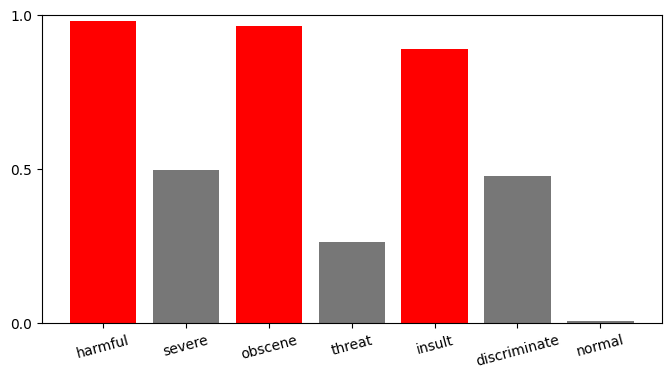

Dear god this site is horrible.


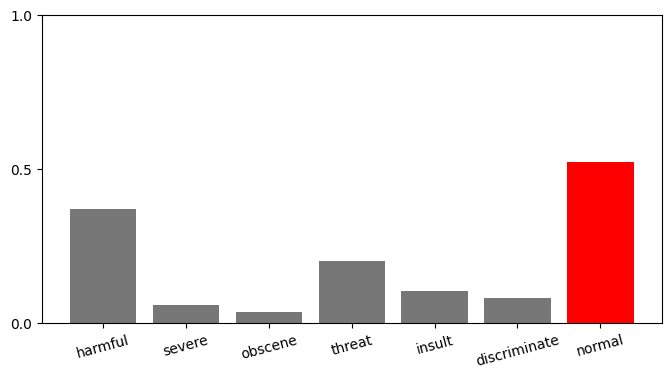

Only a fool can believe in such numbers.


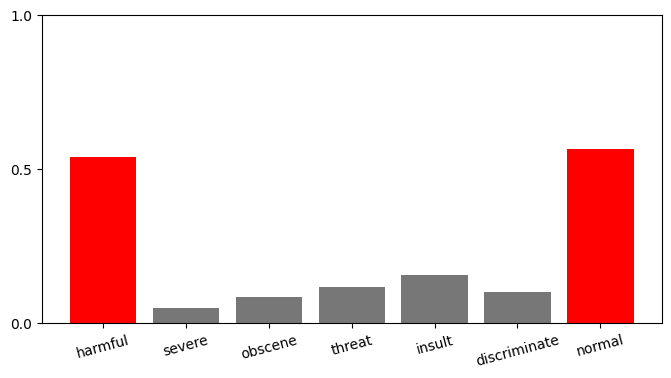

I have indefinitely blocked this account.


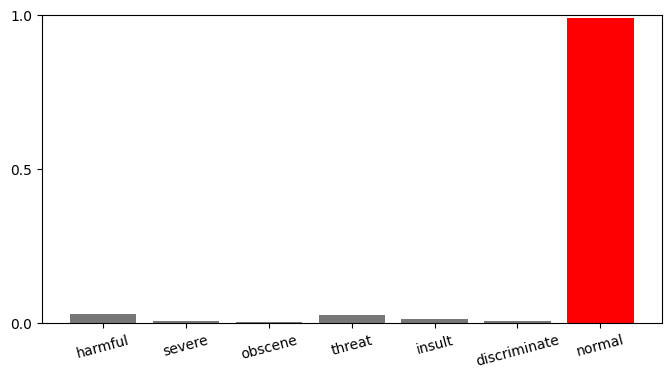

Love the commitment bitch


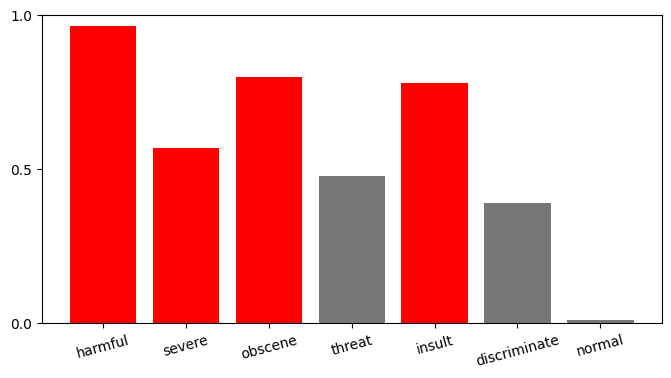

hello how are you


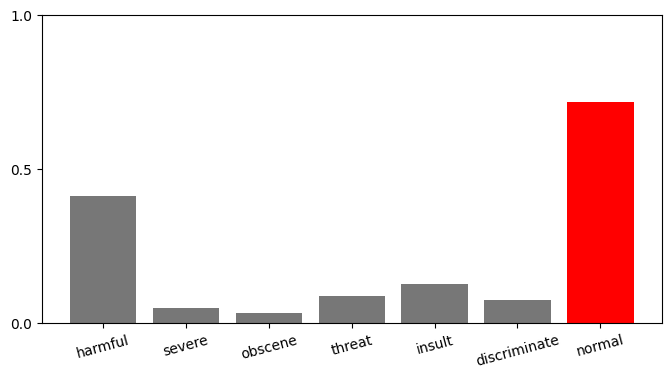

I hate gay people


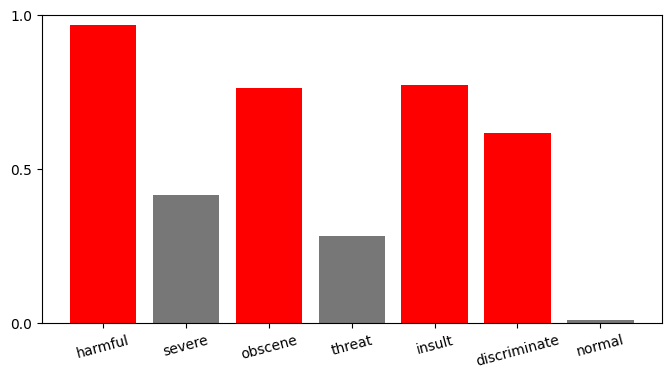

I hate myself


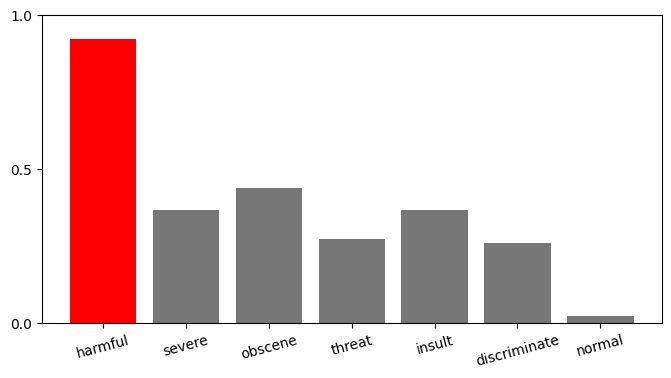

In [ ]:
inputs = [
  "Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",
  "Dear god this site is horrible.",
  "Only a fool can believe in such numbers.",
  "I have indefinitely blocked this account.",
  "Love the commitment bitch",
  "hello how are you",
  "I hate gay people",
  "I hate myself"
]

examples = tf.constant(inputs)
def plot_value_array(prediction):
  colors=["red" if pred >= 0.5 else "#777777" for pred in prediction]
  thisplot = plt.bar(range(len(prediction)), prediction, color=colors)
  plt.xticks(range(len(prediction)), ['harmful', 'severe', 'obscene', 'threat', 'insult', 'discriminate', 'normal'], rotation=15)
  plt.yticks([0, 0.5, 1])
  plt.ylim([0, 1])

predictions = model.predict(examples)

for i in range(len(inputs)):
  plt.figure(figsize=(8, 4))
  print(inputs[i])
  plot_value_array(predictions[i])
  plt.show()

In [ ]:
model.save('drive/MyDrive/Models/BERT-CNN-model.keras')